# Interface A/B Test: Does Simplification Increase Conversions?

The client is the representatives of the BitMotion Kit online store, which sells gamified products for those who lead a healthy lifestyle. It has its own target audience, and even has hits: an expander with a counter and reminder, as well as an under-table exercise bike with Bluetooth.

In the future, the company wants to expand the range of products. But before that, it needs to solve one problem. The interface of the online store is too complicated for users — this is what the reviews say.

To attract new customers and increase sales, the store owners developed a new version of the site and tested it on some users. According to the idea, this solution will demonstrably increase the number of users who will make a purchase.

The task is to evaluate the results of the A/B test.

## Purpose and objectives of the study.

It is necessary to test the hypothesis that simplifying the interface of an online store leads to an increase in the conversion of registered users into buyers within 7 days after registration, compared to the current interface.

**Goal** - to find out whether there really was an increase in conversion (at least by 3 percentage points).

**Tasks:**
- Upload and prepare data;
- Check the correctness of the A/B test;
- Evaluate the performance metric;
- Check the statistical significance of the difference;
- Formulate conclusions and recommendations.

## Data description.

The `participants` table contains information about A/B test participants:
- `user_id` - Unique user identifier
- `group` - Test group: A — control, B — test
- `ab_test` - Test name (we are interested in interface_eu_test)
- `device` - Device from which the user registered

The `events` table records user events on the platform:
- `user_id` - User identifier
- `event_dt` - Date and time of the event
- `event_name` - Event name
- `details` - Additional information

## Data and its integrity.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from scipy import stats

!pip install matplotlib-venn -q
from matplotlib_venn import venn2

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

display('participants')
display(participants.head())
display(participants.info())

display('events')
display(events.head())
display(events.info())

'participants'

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

'events'

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

The `participants` table contains information about A/B test participants. It consists of 14,525 rows and 4 fields, without missing values. The data types are correct.

The `events` table records user events on the platform. It consists of 787,286 rows and 4 fields. The data types are correct. There are gaps in the "details" column.

Let's check for complete duplicates in the events table, and if there are any, we'll delete them.

In [3]:
duplicates_events = events.duplicated().sum()
print(f"Number of complete duplicates in the events table: {duplicates_events}")

# Remove duplicates
if duplicates_events > 0:
    events = events.drop_duplicates()
    print("Duplicates removed.")
else:
    print("There are no duplicates.")

Number of complete duplicates in the events table: 36318
Duplicates removed.


When looking at `participants`, it was clear that in addition to the test we are interested in, the table also contains data on another experiment, `recommender_system_test`. It is important for us to select only those users who participated in one experimental group (B), and not in both tests at once.

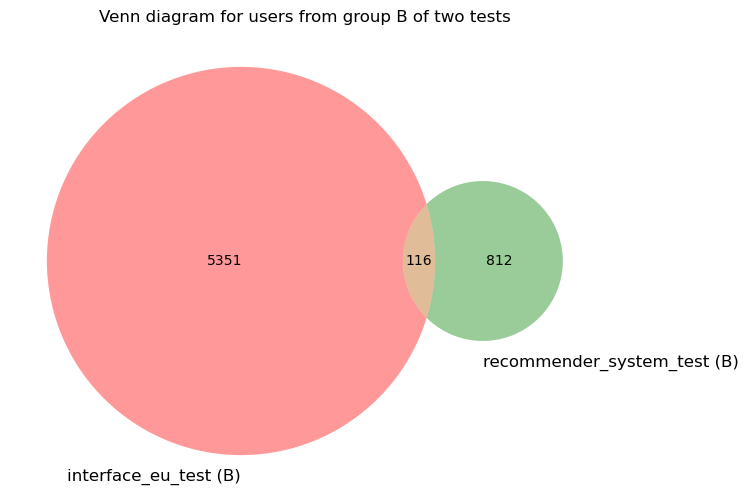

In [4]:
# Set data for users from group B of both tests
test_1_group_B = set(participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]['user_id'])
test_2_group_B = set(participants[(participants['ab_test'] == 'recommender_system_test') & (participants['group'] == 'B')]['user_id'])

# Find the intersection of users from group B of both tests
intersection_B = test_1_group_B.intersection(test_2_group_B)

# We construct a Venn diagram for users from group B of both tests
plt.figure(figsize=(8, 6))
venn2([test_1_group_B, test_2_group_B], set_labels=('interface_eu_test (B)', 'recommender_system_test (B)'))

plt.title("Venn diagram for users from group B of two tests")

plt.show()

In [5]:
# Remove users who participate in two tests at the same time in group B
participants_cleaned = participants[~participants['user_id'].isin(intersection_B)]

# Check that the crossed users were deleted
remaining_intersections = participants_cleaned[(participants_cleaned['user_id'].isin(intersection_B))]
print(f"Number of remaining intersections: {remaining_intersections.shape[0]}")

display(participants_cleaned.head())

Number of remaining intersections: 0


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Now we will leave only the data for the test `interface_eu_test`

In [6]:
participants_test = participants_cleaned[participants_cleaned['ab_test'] == 'interface_eu_test']

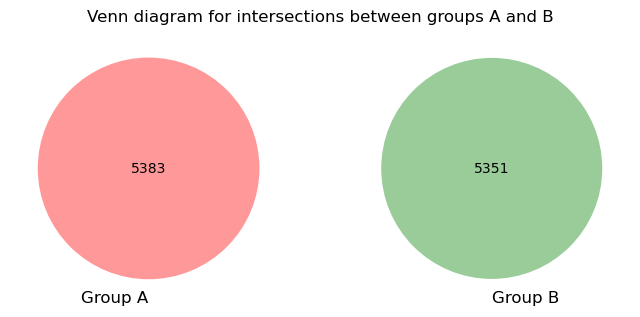

In [7]:
# Find the intersection of users between groups A and B of our test
group_A_users = set(participants_test[participants_test['group'] == 'A']['user_id'])
group_B_users = set(participants_test[participants_test['group'] == 'B']['user_id'])

# Venn diagram
plt.figure(figsize=(8, 6))
venn2([group_A_users, group_B_users], set_labels=('Group A', 'Group B'))

plt.title("Venn diagram for intersections between groups A and B")

plt.show()

Let's check the distribution by groups

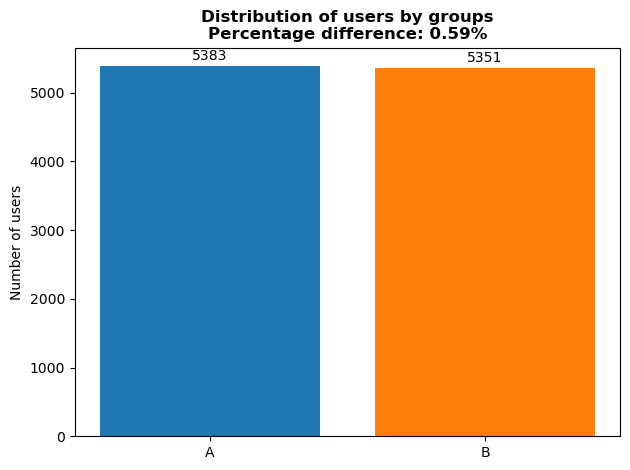

In [8]:
# Count the number of users in each group
group_distribution = participants_test['group'].value_counts()

# Extract values
group_A = group_distribution.get('A', 0)
group_B = group_distribution.get('B', 0)

# Calculate the percentage difference
percent_diff = 100 * abs(group_A - group_B) / group_A

# Plotting a diagram
fig, ax = plt.subplots()
bars = ax.bar(['A', 'B'], [group_A, group_B], color=['#1f77b4', '#ff7f0e'])

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + max(group_A, group_B) * 0.01, f'{yval}', ha='center', va='bottom')

ax.set_title(f'Distribution of users by groups\nPercentage difference: {percent_diff:.2f}%', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of users')

plt.tight_layout()
plt.show()

The difference between the groups is only 0.59%. This means that the distribution of users between A and B is almost perfectly balanced. In addition, the groups do not overlap.

In [9]:
# Let's leave events only for users from the interface_eu_test test
test_user_ids = participants_test['user_id'].unique()
events_test = events[events['user_id'].isin(test_user_ids)]

print(f'Number of rows in the filtered table: {events_test.shape[0]}')
display(events_test.head())

Number of rows in the filtered table: 72935


,user_id,event_dt,event_name,details
64672,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
64946,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32
67873,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0


Let's calculate the time (lifetime) of the user performing an event after registration and leave only those events that were performed within the first seven days from the moment of registration

In [10]:
# Get only the earliest registration events for each user
registrations = (
    events_test[events_test['event_name'] == 'registration']
    .groupby('user_id', as_index=False)['event_dt']
    .min()
    .rename(columns={'event_dt': 'registration_dt'})
)

In [11]:
# Combine it with other events by user_id
events_with_reg = events_test.merge(registrations, on='user_id')

# Calculate the time difference (lifetime)
events_with_reg['lifetime'] = (events_with_reg['event_dt'] - events_with_reg['registration_dt']).dt.days

# Leave only the events that happened during the first 7 days
events_7d = events_with_reg[events_with_reg['lifetime'] < 7]

display(events_7d.head())

,user_id,event_dt,event_name,details,registration_dt,lifetime
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,2020-12-06 14:37:25,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,2020-12-06 17:20:22,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,2020-12-06 19:36:54,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,2020-12-06 19:42:20,0


In [12]:
# Merge tables
merged_data = events_7d.merge(participants_test[['user_id', 'group']], on='user_id', how='left')

display(merged_data.head())
display(merged_data.info())

,user_id,event_dt,event_name,details,registration_dt,lifetime,group
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0,A
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,2020-12-06 14:37:25,0,A
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,2020-12-06 17:20:22,0,B
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,2020-12-06 19:36:54,0,A
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,2020-12-06 19:42:20,0,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62934 entries, 0 to 62933
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          62934 non-null  object        
 1   event_dt         62934 non-null  datetime64[ns]
 2   event_name       62934 non-null  object        
 3   details          16969 non-null  object        
 4   registration_dt  62934 non-null  datetime64[ns]
 5   lifetime         62934 non-null  int64         
 6   group            62934 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 3.4+ MB


None

Let's evaluate the sufficiency of the sample to obtain statistically significant results of the A/B test. Given parameters:

- base conversion rate — 30%,

- test power — 80%,

- test reliability — 95%.

- expected increase is 3 p.p.

In [13]:
p0 = 0.30  
p1 = 0.33  
alpha = 0.05  
power = 0.80

# Calculate the sample size
analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=proportion_effectsize(p0, p1), power=power, alpha=alpha, ratio=1)

# Результат
required_n

3761.596974012117

- Group A has 5 383 users.
- Group B has 5 351 users.

Since the number of users in both groups is significantly larger than the required 3 762, we can say that the sample is large enough to obtain statistically significant results.

Let's calculate for each group the number of visitors who made a purchase and the total number of visitors.

In [14]:
# Select only registration and purchase events
purchase_data = merged_data[merged_data['event_name'].isin(['registration', 'purchase'])]

# Create a pivot table
result_table = purchase_data.pivot_table(index='group', 
                                       columns='event_name', 
                                       values='user_id', 
                                       aggfunc='nunique')

# Add a column with conversion (purchases / registrations)
result_table['Conversion Rate'] = result_table['purchase'] / result_table['registration']

# Format conversion to percentage
result_table['Conversion Rate'] = result_table['Conversion Rate'].apply(lambda x: f'{x:.2%}')

# Rename columns
result_table = result_table[['registration', 'purchase', 'Conversion Rate']]

# Rename columns
result_table.columns = ['Total Users', 'Purchases', 'Conversion Rate']

result_table

,Total Users,Purchases,Conversion Rate
group,,,
A,5383,1480,27.49%
B,5351,1579,29.51%


In test group B, where users interacted with the new simplified interface, there was a slight increase in conversion to purchase compared to control group A:
- In group A (control), the conversion was 27.49%
- In group B (test), the conversion was 29.51%

This may indicate that the new interface has a positive effect on user activity and motivation to purchase, but for final conclusions, it is necessary to statistically test the significance of this difference.
In addition, when we calculated a sufficient sample size, we hypothesized that the new interface would increase conversion from 30% to 33% - that is, by 3 percentage points, which corresponds to a relative increase of 10%.
Actual increase:
- Absolute: 29.51% - 27.49% = 2.02 p.p.
- Relative: (29.51 - 27.49) / 27.49 ≈ 7.35%

There is growth, but it is less than expected: we planned +3 p.p., but got +2.02 p.p.

## A/B testing results evaluation:

H₀ (null hypothesis): Conversion in group B is not higher than in A.

H₁ (alternative hypothesis): Conversion in group B is higher than in A.

In [15]:
# Count the number of successful purchases and the total number of users in each group
success_b = result_table.loc['B', 'Purchases']
total_b = result_table.loc['B', 'Total Users']

success_a = result_table.loc['A', 'Purchases']
total_a = result_table.loc['A', 'Total Users']

# Form arrays for the test
successes = [success_b, success_a]
samples = [total_b, total_a]

# Perform a one-tailed Z-test
stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='larger')

# Output the result
print(f"p-value: {p_value:.5f}")

if p_value < 0.05:
    print("The difference is statistically significant. Conversion to purchase in group B is higher than in A.")
else:
    print("The difference is not statistically significant. Conversion to purchase in group B is not higher than in A.")

p-value: 0.01039
The difference is statistically significant. Conversion to purchase in group B is higher than in A.


The A/B test assessed the impact of the new, simplified interface (`group B`) on user conversion to purchases compared to the current interface (`group A`).
**The goal** of the experiment was to achieve an increase in conversion of at least <u>3</u> percentage points (p.p.), which corresponds to a relative increase of <u>10%</u>.

**Actual test results:**
- Conversion in group A (control): 27.49%
- Conversion in group B (test): 29.51%
- Absolute increase: <u>+2.02 p.p.</u>
- Relative increase: <u>+7.35%</u>

p-value: `0.01` (the difference is statistically significant)

**Conclusion:**
The test group showed a significant improvement in conversion - the conversion to purchase is higher than in the control group. This indicates a positive effect of the new interface on user activity.

However, the expected effect (+3 p.p.) was not achieved — the actual increase was only <u>+2.02 p.p.</u>, which is lower than the planned increase.

Thus, the hypothesis about the increase in conversion is confirmed statistically, but <u>the planned scale of the effect was not achieved</u>.

*Recommendations for increasing conversion:*

- *Consider the possibility of additional testing iterations, where you can test in more detail specific interface elements that can affect conversion. For example, optimizing the "buy" buttons or simplifying the checkout process.*

- *Analyze the behavior of users in group B to identify which aspects of the interface can hinder greater conversion growth. For example, collect data on the user's path, studying at what step they often leave the site.*

**General recommendation** - evaluate the ratio between the costs of implementing a new interface and the resulting increase in conversion in order to decide on its full implementation.